# STDP

The purpose of this notebook is to investigate the default dynamics of STDP-type rules, in feedforward and recurrent networks, with Poisson and simple behaviour.

This notebook needs a redesign.

For responsive neurons, we'll use conductance-based synapses:
$$
\begin{align}
\tau_m \frac{dv}{dt} &= g_e (E_e - v_r) + E_l - v\\
\tau_e \frac{g_e}{dt} &= - g_e + \sum_i S_j
\end{align}
$$
where $S_j$ denotes the spike-train input from neuron $j$.

Various combinations of learning rules and neuron models are allowed:  
* Whether or not to include recurrent weights on the output population. Without recurrent weights, we're effectively doing multiple simulations simultaneously.
* Which learning rule to include: STDP, $\mu$-STDP, W-STDP, Triplet, $\mu$-Triplet

In [18]:
%%writefile equations.py
# This file contains equations for the Brian2 STDP experiments
# There is one neuron model we'll consider
neuron_model = '''
    dv/dt = (ge * (Ee-vr) + El - v) / taum : volt
    dge/dt = -ge / taue : 1
    '''

# There are various synapse models for the different learning rules
synapse_model_STDP = '''
    w : 1
    dxj/dt = -xj / taupre : 1 (event-driven)
    dyi/dt = -yi / taupost : 1 (event-driven)
    '''
synapse_model_Triplet = '''
    w : 1
    dxj/dt = -xj / taupre : 1 (event-driven)
    dyi/dt = -yi / taupost : 1 (event-driven)
    dyi2/dt = -yi2 / taupost_slow : 1 (event-driven)
    '''

# responsive post-synaptic neurons are induced to fire
on_pre_responsive = '''
    ge += w
    '''

# various learning rules have different on_pre and on_post behaviour
on_pre_STDP = '''
    xj += 1
    w = clip(w + Aminus * yi, 0, gmax)
    '''
on_post_STDP = '''
    yi += 1
    w = clip(w + Aplus * xj, 0, gmax)
    '''

# mu-STDP is the rule with (exponentially) scaled weight dependence
on_pre_muSTDP = '''
    xj += 1
    w = clip(w + Aminus * yi * (w**mu), 0, gmax)
    '''
on_post_muSTDP = '''
    yi += 1
    w = clip(w + Aplus * xj * (gmax-w)**mu, 0, gmax)
    '''

# W-STDP has the same potentiation dynamics as STDP
on_pre_WSTDP = '''
    xj += 1
    w = clip(w + Aminus * yi * w, 0, gmax)
    '''
on_post_WSTDP = on_post_STDP

# we only consider the "minimal Triplet rule" where LTP is triplet-driven
on_pre_Triplet = '''
    xj += 1
    w = clip(w + Aminus * yi, 0, gmax)
    '''
on_post_Triplet = '''
    yi += 1
    w = clip(w + Aplus * xj * yi2, 0, gmax)
    yi2 += 1
    '''

# mu-Triplet is to the mu-STDP Rule as Triplet is to the STDP rule
on_pre_muTriplet = on_pre_muSTDP
on_post_muTriplet = '''
    yi += 1
    w = clip(w + Aplus * xj * yi2 * (gmax-w)**mu, 0, gmax)
    yi2 += 1
    '''

Overwriting equations.py


In [19]:
%load_ext autoreload
%autoreload 2
# Imports
import brian2 as b2
from brian2 import numpy as np

from equations import *

from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
# parameters (replace with argparse)
N_input = 1000  # used if share_input is True
N_output = 100
share_input = True  # if True, input is all-to-all; otherwise 1-to-1
recurrent_weights = 1  # 0 = None, 1 = plastic, 2 = static with same learning rule
learning_rule = 'Triplet'  # in ['STDP', 'WSTDP', 'muSTDP', 'Triplet', 'muTriplet']
responsive_neurons = False

runtime = 100*b2.second
N_weight_traces = 4  # number of weights per synapse group to record traces of

input_rate = 15 * b2.Hz  # remember to scale up if share_input is False as output neurons will only have one input each
output_rate = 20 * b2.Hz  # firing rate of output population if not responsive

# Synapse behaviour
taupre = 20*b2.ms
taupost = taupre
taupost_slow = 55*b2.ms  # only used with Triplet LTP
mu = 0.05  # only used with muX rules

gmax = 0.01
# dApre = 0.01
# dApost = -1.05 * dApre * taupre / taupost
# # Normalized to jump to max value with each spike
# dApost *= gmax
# dApre *= gmax
# dApost_slow = dApost

Aminus = dApost
Aplus = dApre
Aplus = 0.01
Aminus = -1.05*Aplus * taupre / taupost
# Normalized to jump to max value with each spike
# and inherit the units of gmax
Aplus *= gmax
Aminus *= gmax


# Responsive neurons behaviour
taum = 10*b2.ms
Ee = 0*b2.mV
vt = -54*b2.mV
vr = -60*b2.mV
El = -74*b2.mV
taue = 5*b2.ms

In [56]:
# build model
b2.start_scope()

if not share_input:
    N_input = N_output

input_group = b2.PoissonGroup(
    N=N_input,
    rates=input_rate
)
   
if responsive_neurons:
    output_group = b2.NeuronGroup(
        N=N_output,
        model=neuron_model,
        threshold='v>vt',
        reset='v = vr',
        method='linear'
    )
else:
    output_group = b2.PoissonGroup(
        N=N_output,
        rates=output_rate
    )

selected_synapse_model = None
selected_on_pre = None
selected_on_post = None
if learning_rule == 'STDP':
    selected_synapse_model = synapse_model_STDP
    selected_on_pre = on_pre_STDP
    selected_on_post = on_post_STDP
elif learning_rule == 'WSTDP':
    selected_synapse_model = synapse_model_STDP
    selected_on_pre = on_pre_WSTDP
    selected_on_post = on_post_WSTDP
elif learning_rule == 'muSTDP':
    selected_synapse_model = synapse_model_STDP
    selected_on_pre = on_pre_muSTDP
    selected_on_post = on_post_muSTDP
elif learning_rule == 'Triplet':
    selected_synapse_model = synapse_model_Triplet
    selected_on_pre = on_pre_Triplet
    selected_on_post = on_post_Triplet
elif learning_rule == 'muTriplet':
    selected_synapse_model = synapse_model_Triplet
    selected_on_pre = on_pre_muTriplet
    selected_on_post = on_post_muTriplet

if responsive_neurons:
    selected_on_pre = selected_on_pre + on_pre_responsive
    
synapse_input = b2.Synapses(
    source=input_group,
    target=output_group,
    model=selected_synapse_model,
    on_pre=selected_on_pre,
    on_post=selected_on_post,
    )
if share_input:
    synapse_input.connect()
else:
    synapse_input.connect('i==j')
synapse_input.w = 'rand() * gmax'

if recurrent_weights == 1:
    synapse_recurrent = b2.Synapses(
        source=output_group,
        target=output_group,
        model=selected_synapse_model,
        on_pre=selected_on_pre,
        on_post=selected_on_post,
         )
    synapse_recurrent.connect('i!=j')
    synapse_recurrent.w = 'rand() * gmax'
elif recurrent_weights >= 2:
    raise Exception('Static recurrent weights not implemented yet.')

In [57]:
# place monitors
ratemon = b2.PopulationRateMonitor(
    output_group
)
statemon_input = b2.StateMonitor(
    synapse_input,
    'w', record=np.arange(N_weight_traces)
)
input_weights_before = np.zeros((N_input, N_output))
input_weights_before[synapse_input.i[:], synapse_input.j[:]] = synapse_input.w[:]

if recurrent_weights:
    statemon_recurrent = b2.StateMonitor(
        synapse_recurrent,
        'w', record=np.arange(N_weight_traces)
    )
    recurrent_weights_before = np.zeros((N_output,N_output))
    recurrent_weights_before[synapse_recurrent.i[:], synapse_recurrent.j[:]] = synapse_recurrent.w[:]

In [58]:
# run model
b2.run(runtime, report='text')

# bins = 50
# weights_array = np.zeros((bins, N_RUNS))

# # net = b2.Network(b2.collect())

# b2.store('initialized')
# for run_idx in tqdm(range(N_RUNS)):
#     b2.restore('initialized')
#     synapse_input.mu = mu_vals[run_idx]
#     b2.run(100*b2.second)  #, report='text')
#     w_hist, _, _ = b2.hist(synapse_input.w, range=(0,gmax), bins=bins, density=True)
#     weights_array[:, run_idx] = w_hist

Starting simulation at t=0. s for a duration of 100. s
9.9928 (9%) simulated in 10s, estimated 1m 30s remaining.
19.889100000000003 (19%) simulated in 20s, estimated 1m 21s remaining.
29.7601 (29%) simulated in 30s, estimated 1m 11s remaining.
39.6439 (39%) simulated in 40s, estimated 1m 1s remaining.
49.5263 (49%) simulated in 50s, estimated 51s remaining.
59.39840000000001 (59%) simulated in 1m 0s, estimated 41s remaining.
69.4391 (69%) simulated in 1m 10s, estimated 31s remaining.
79.44080000000001 (79%) simulated in 1m 20s, estimated 21s remaining.
89.4573 (89%) simulated in 1m 30s, estimated 11s remaining.
99.491 (99%) simulated in 1m 40s, estimated 1s remaining.
100.0 (100%) simulated in 1m 40s


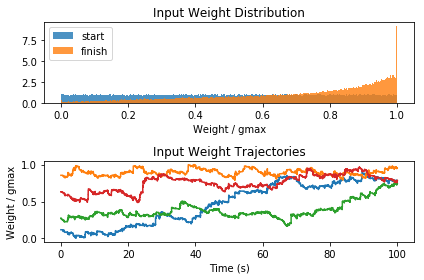

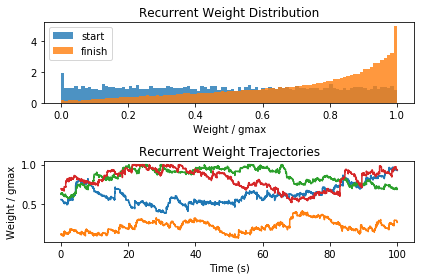

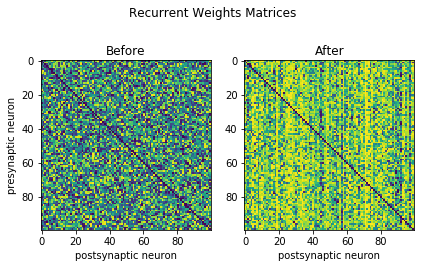

In [59]:
b2.figure()
b2.subplot(211)
b2.title('Input Weight Distribution')
b2.hist(
    input_weights_before.ravel() / gmax,
    int(np.sqrt(synapse_input.w.shape)),
    density=True,
    label='start',
    alpha=0.8
)
b2.hist(
    synapse_input.w / gmax,
    int(np.sqrt(synapse_input.w.shape)),
    density=True,
    label='finish',
    alpha=0.8
)
b2.legend()
b2.xlabel('Weight / gmax')

b2.subplot(212)
b2.title('Input Weight Trajectories')
b2.plot(statemon_input.t/b2.second, statemon_input.w.T/gmax)
b2.xlabel('Time (s)')
b2.ylabel('Weight / gmax')
b2.tight_layout()

if recurrent_weights:
    b2.figure()
    b2.subplot(211)
    b2.title('Recurrent Weight Distribution')
    b2.hist(
    recurrent_weights_before.ravel() / gmax,
    int(np.sqrt(synapse_recurrent.w.shape)),
    density=True,
    label='start',
    alpha=0.8
    )
    b2.hist(
    synapse_input.w / gmax,
    int(np.sqrt(synapse_recurrent.w.shape)),
    density=True,
    label='finish',
    alpha=0.8
    )
    b2.legend()
    b2.xlabel('Weight / gmax')

    b2.subplot(212)
    b2.title('Recurrent Weight Trajectories')
    b2.plot(statemon_recurrent.t/b2.second, statemon_recurrent.w.T/gmax)
    b2.xlabel('Time (s)')
    b2.ylabel('Weight / gmax')
    b2.tight_layout()

    
    b2.figure()
    recurrent_weights_after = np.zeros((N_output,N_output))
    recurrent_weights_after[synapse_recurrent.i[:], synapse_recurrent.j[:]] = synapse_recurrent.w[:]
    
    b2.suptitle('Recurrent Weights Matrices')
    b2.subplot(121)
    b2.title('Before')
    b2.imshow(recurrent_weights_before)
    b2.ylabel('presynaptic neuron')
    b2.xlabel('postsynaptic neuron')
    b2.subplot(122)
    b2.title('After')
    b2.imshow(recurrent_weights_after)
    b2.xlabel('postsynaptic neuron')
    b2.tight_layout()

if responsive_neurons:
    b2.figure()
    b2.plot(ratemon.t / b2.second, ratemon.smooth_rate(window='gaussian', width=100*b2.ms)/b2.Hz)
    b2.xlabel('Time (s)')
    b2.ylabel('Output Rate (Hz)')
b2.show()

____

## STDP on Poisson Neurons

In [19]:
USE_TRIPLET = False
USE_WEIGHT_DEPENDENCE = True
USE_RESPONSIVE_NEURONS = False
USE_RECURRENCE = False
N_RUNS = 50

100%|██████████| 1/1 [01:34<00:00, 94.49s/it]


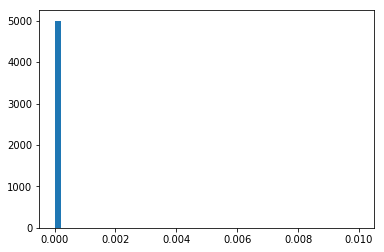

In [5]:
b2.start_scope()

N_input = 1000
N_output = 100
input_rate = 25 * b2.Hz  # should be compared with STDP kernel width
output_rate = 15 * b2.Hz

taum = 10*b2.ms
taupre = 20*b2.ms
taupost = taupre
taupost_slow = 100*b2.ms
# mu = 0.05
mu_vals = np.linspace(0, 1, N_RUNS)

gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost
if not (USE_TRIPLET or USE_WEIGHT_DEPENDENCE):
    dApost *= 1.05
dApost *= gmax
dApre *= gmax

Ee = 0*b2.mV
vt = -54*b2.mV
vr = -60*b2.mV
El = -74*b2.mV
taue = 5*b2.ms

neuron_model = '''
dv/dt = (ge * (Ee-vr) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

synapse_model = '''
    w : 1
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)
    mu : 1
    '''
if USE_TRIPLET:
    synapse_model += '''
        dApost_slow/dt = -Apost_slow / taupost_slow : 1 (event-driven)
        '''
if USE_WEIGHT_DEPENDENCE:
    on_pre = '''
        Apre += dApre
        w = clip(w + Apost*w**mu, 0, gmax)
        '''
else:
    on_pre = '''
        Apre += dApre
        w = clip(w + Apost, 0, gmax)
        '''
if USE_RESPONSIVE_NEURONS:
    on_pre += '''
        ge += w
        '''
if USE_TRIPLET:
    if USE_WEIGHT_DEPENDENCE:
        on_post = '''
            Apost += dApost
            w = clip(w + Apre*Apost_slow*(gmax-w)**mu, 0, gmax)
            Apost_slow += dApost
            '''
    else:
        on_post = '''
            Apost += dApost
            w = clip(w + Apre*Apost_slow, 0, gmax)
            Apost_slow += dApost
            '''
else:
    if USE_WEIGHT_DEPENDENCE:
        on_post = '''
            Apost += dApost
            w = clip(w + Apre*(gmax-w)**mu, 0, gmax)
            '''
    else:
        on_post = '''
            Apost += dApost
            w = clip(w + Apre, 0, gmax)
            '''

input_group = b2.PoissonGroup(
    N=N_input,
    rates=input_rate
)
if USE_RESPONSIVE_NEURONS:
    output_group = b2.NeuronGroup(
        N=N_output,
        model=neuron_model,
        threshold='v>vt',
        reset='v = vr',
        method='linear'
    )
    ratemon = b2.PopulationRateMonitor(
        output_group
    )
else:
    output_group = b2.PoissonGroup(
        N=N_output,
        rates=output_rate
    )

synapse_input = b2.Synapses(
    source=input_group,
    target=output_group,
    model=synapse_model,
    on_pre=on_pre,
    on_post=on_post,
     )
synapse_input.connect()
synapse_input.w = 'rand() * gmax'
statemon_input = b2.StateMonitor(synapse_input, 'w', record=[0, 1])

if USE_RECURRENCE:
    synapse_recurrent = b2.Synapses(
        source=output_group,
        target=output_group,
        model=synapse_model,
        on_pre=on_pre,
        on_post=on_post,
         )
    synapse_recurrent.connect()
    synapse_recurrent.w = 'rand() * gmax'
    statemon_recurrent = b2.StateMonitor(synapse_recurrent, 'w', record=[0, 1])

    weights_before = np.zeros((N_output,N_output))
    weights_before[synapse_recurrent.i[:], synapse_recurrent.j[:]] = synapse_recurrent.w[:]

bins = 50
weights_array = np.zeros((bins, N_RUNS))

# net = b2.Network(b2.collect())

b2.store('initialized')
for run_idx in tqdm(range(N_RUNS)):
    b2.restore('initialized')
    synapse_input.mu = mu_vals[run_idx]
    b2.run(100*b2.second)  #, report='text')
    w_hist, _, _ = b2.hist(synapse_input.w, range=(0,gmax), bins=bins, density=True)
    weights_array[:, run_idx] = w_hist

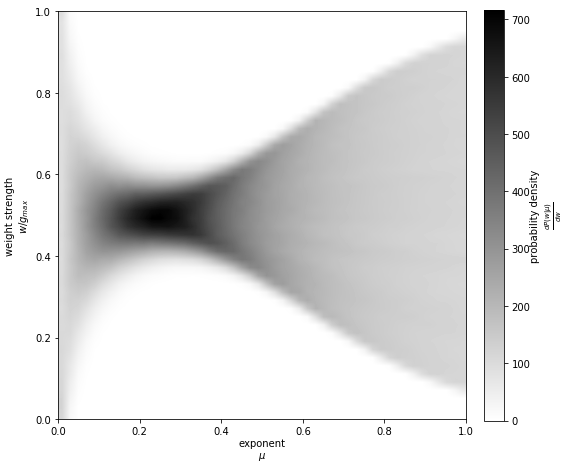

In [62]:
from matplotlib import cm
import os

OVERWRITE = False
figname = 'weight-dependent STDP distributions.png'

b2.figure(figsize=(12, ))
extent = [0, 1, 0, 1]
b2.imshow(
    weights_array,
    cmap=cm.gray_r,
    interpolation='bilinear',
    extent=extent)
b2.xlabel('exponent\n$\mu$')
b2.ylabel('weight strength\n'+r'$w/g_{max}$')
b2.colorbar(label='probability density\n'+r'$\frac{dP(w|\mu)}{dw}$', fraction=0.046, pad=0.04)

if figname not in os.listdir() or OVERWRITE:
    b2.savefig(figname)

b2.show()

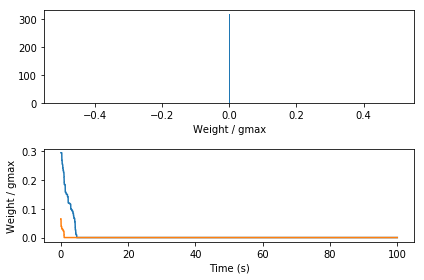

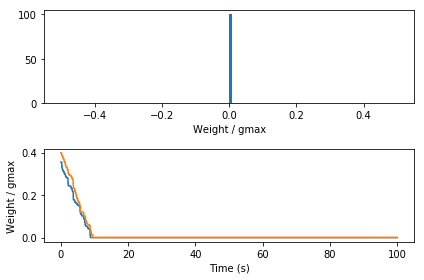

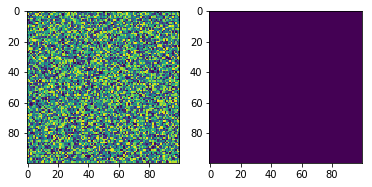

In [6]:
# b2.subplot(311)
# b2.plot(synapse_input.w / gmax, '.k')
# b2.ylabel('Weight / gmax')
# b2.xlabel('Synapse index')
b2.figure()
b2.subplot(211)
b2.hist(synapse_input.w / gmax, int(np.sqrt(synapse_input.w.shape)), density=True)
b2.xlabel('Weight / gmax')
b2.subplot(212)
b2.plot(statemon_input.t/b2.second, statemon_input.w.T/gmax)
b2.xlabel('Time (s)')
b2.ylabel('Weight / gmax')
b2.tight_layout()

if USE_RECURRENCE:
    b2.figure()
    b2.subplot(211)
    b2.hist(synapse_recurrent.w / gmax, int(np.sqrt(synapse_recurrent.w.shape)), density=True)
    b2.xlabel('Weight / gmax')
    b2.subplot(212)
    b2.plot(statemon_recurrent.t/b2.second, statemon_recurrent.w.T/gmax)
    b2.xlabel('Time (s)')
    b2.ylabel('Weight / gmax')
    b2.tight_layout()

    b2.figure()
    weights_after = np.zeros((N_output,N_output))
    weights_after[synapse_recurrent.i[:], synapse_recurrent.j[:]] = synapse_recurrent.w[:]
    b2.subplot(121)
    b2.imshow(weights_before)
    b2.subplot(122)
    b2.imshow(weights_after)

if USE_RESPONSIVE_NEURONS:
    b2.figure()
    b2.plot(ratemon.t / b2.second, ratemon.smooth_rate(window='gaussian', width=100*b2.ms)/b2.Hz)
    b2.xlabel('Time (s)')
    b2.ylabel('Output Rate (Hz)')
b2.show()

## STDP on Responsive Output Neurons

Starting simulation at t=0. s for a duration of 100. s
14.629800000000001 (14%) simulated in 10s, estimated 58s remaining.
29.3186 (29%) simulated in 20s, estimated 48s remaining.
44.0277 (44%) simulated in 30s, estimated 38s remaining.
58.7068 (58%) simulated in 40s, estimated 28s remaining.
73.4423 (73%) simulated in 50s, estimated 18s remaining.
88.14240000000001 (88%) simulated in 1m 0s, estimated 8s remaining.
100.0 (100%) simulated in 1m 8s


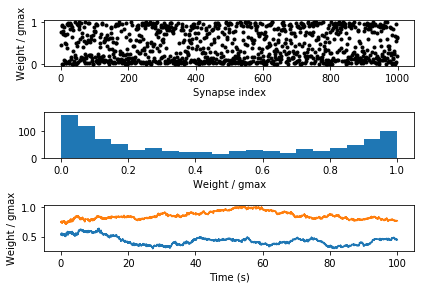

In [9]:
b2.start_scope()

N = 1000
taum = 10*b2.ms
taupre = 20*b2.ms
taupost = taupre
Ee = 0*b2.mV
vt = -54*b2.mV
vr = -60*b2.mV
El = -74*b2.mV
taue = 5*b2.ms

eqs_neurons = '''
dv/dt = (ge * (Ee-vr) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

F = 15*b2.Hz
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

eqs_neurons = '''
dv/dt = (ge * (Ee-vr) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

input = b2.PoissonGroup(N, rates=F)
neurons = b2.NeuronGroup(1, eqs_neurons, threshold='v>vt', reset='v = vr',
                      method='linear')
S = b2.Synapses(input, neurons,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )
S.connect()
S.w = 'rand() * gmax'
state_mon = b2.StateMonitor(S, 'w', record=[0, 1])
spike_mon = b2.SpikeMonitor(input)
rate_mon = b2.PopulationRateMonitor(neurons)

b2.run(100*b2.second, report='text')

b2.subplot(311)
b2.plot(S.w / gmax, '.k')
b2.ylabel('Weight / gmax')
b2.xlabel('Synapse index')
b2.subplot(312)
b2.hist(S.w / gmax, 20)
b2.xlabel('Weight / gmax')
b2.subplot(313)
b2.plot(state_mon.t/b2.second, state_mon.w.T/gmax)
b2.xlabel('Time (s)')
b2.ylabel('Weight / gmax')
b2.tight_layout()
b2.show()

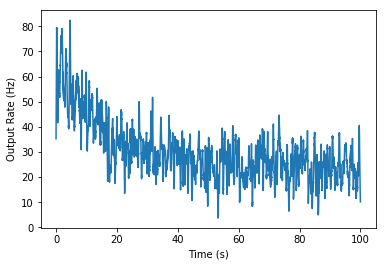

In [21]:
b2.plot(rate_mon.t/b2.second, rate_mon.smooth_rate(window='gaussian', width=100*b2.ms)/b2.Hz)
b2.xlabel('Time (s)')
b2.ylabel('Output Rate (Hz)')
b2.show()